<딥러닝 파이토치 교과서> ch5. 2 p.179~200
#5.2 합성곱 신경망 맛보기


## fashion_mnist 데이터셋을 사용하여 합성곱 신경망 직접 구현

`fashion_mnist` 데이터셋
- 토치비전에 내장된 예제 데이터
- `train_images`: 0~255 사이값을 갖는 28x28 크기의 넘파일 배열
- `test_labels`: 0~9까지의 정수값을 갖는 레이블(정답) 배열

In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

파이토치는 기본적으로 GPU 사용을 권장. But, GPU가 장착되지 않은 환경에서도 파이토치를 정상적으로 실행하고 사용할 수 있음.
- 하나의 GPU를 사용할 때 일반적으로 사용하는 코드


```
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
```


- 사용하는 PC에서 다수의 GPU를 사용한다면 다음 코드와 같이 `nn.DataParallel`을 사용



```
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
if torch.cuda.device_count() > 1:
  model = nn.DataParallel(net)
model.to(device)
```



In [2]:
# CPU 혹은 GPU 장치 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST('/content/sample_data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('/content/sample_data', download=True, transform=transforms.Compose([transforms.ToTensor()]))

- `torchvision.datasets`는 `torch.utils.data.Dataset`의 하위 클래스
- 다양한 데이터셋 (CIFAR, COCO, MNIST, ImageNet) 을 포함
- 주요 파라미터
   - `'/content/sample_data'`: FashionMNIST를 다운받을 위치를 지정
   - `download=True`: 지정된 위치에 해당 데이터셋이 있는지 확인 후 내려받음.
   - `transform=transforms.Compose([transforms.ToTensor()])`: 이미지를 텐서(0~1)로 변경

In [8]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100) # 100개 단위로 데이터를 묶어서 불러옴.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

`torch.utils.data.DataLoader()`
- 원하는 크기의 배치 단위로 데이터를 불러옴.
- 순서를 무작위로 섞이도록(shuffle) 하는 것 가능.

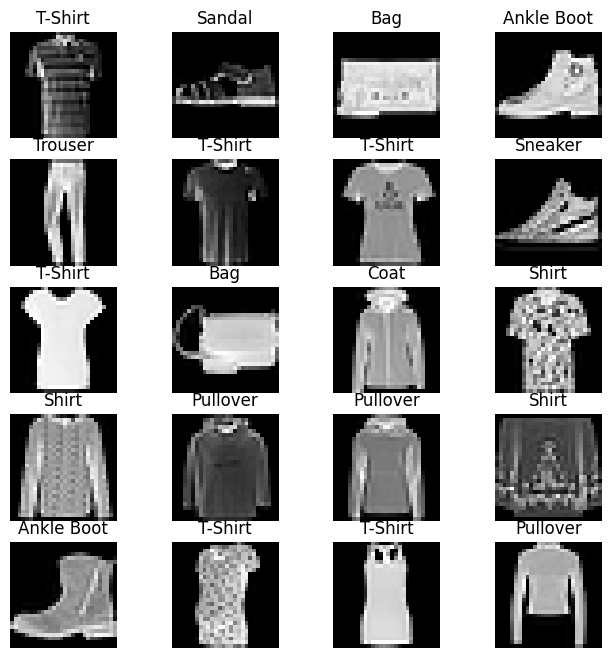

In [9]:
# 분류에 사용될 클래스 정의
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'} # 열 개의 클래스

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows + 1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() # 20개의 이미지를 시각적으로 표현

In [12]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module): # 클래스 형태의 모델은 항상 torch.nn.Module을 상속받음.
  def __init__(self): # ...①
    super(FashionDNN, self).__init__() # nn.Module 클래스를 상속받겠다는 의미
    self.fc1 = nn.Linear(in_features=784, out_features=256) # ...②
    self.drop = nn.Dropout(0.25) # ...③
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data): # ...④
    out = input_data.view(-1, 784) # ...⑤
    out = F.relu(self.fc1(out)) # ...⑥
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

① `def __init__(self):`
- `__init__()`은 객체가 갖는 속성값을 초기화하는 역할. 객체가 생성될 때 자동으로 호출됨.

② `nn.Linear(in_features=784, out_features=256)`
- `nn`은 딥러닝 모델 구성에 필요한 모듈이 모여있는 패키지
- `Linear`은 단순 선형 회귀 모델을 만들 때 사용
   - `in_features`: 입력의 크기
   - `out_features`: 출력의 크기
   - 실제로 데이터 연산이 진행되는 `forward()`부분에선 첫번째 파라미터 값만 넘겨줌.
   - 두번째 차라미터에서 정의된 크기가 `forward()` 연산의 결과

③ `self.drop = nn.Dropout(0.25)`
- p 만큼의 비율로 텐서 값이 0이 됨.
- 0이 되지 않는 값들은 기존 값에 $(1/(1-p))$만큼 곱해져서 커짐.

④ `def forward(self, input_data):`
- `forward()`함수는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행.
- 반드시 "forward"라는 이름의 함수여야 함.
- 객체를 데이터와 함께 호출하면 자동으로 실행됨.


⑤ `out = input_data.view(-1, 784)`
- 파이토피의 view는 텐서의 크기를 변경. 넘파일의 reshape과 같은 역할.
- `input_data`를 (?, 784)의 크기로 변경하라는 의미.

⑥ `out = F.relu(self.fc1(out))`
- 활성화 함수를 지정
- 활성화 함수를 지정할 땐 두가지 방법이 있음.
   - 사용하는 위치, 사용하는 방법에 차이.
1. `F.relu()`
      - `forward()` 함수에서 정의
      - 사용 코드


       ```
       import torch
       import torch.nn as nn

       inputs = torch.randn(64, 3, 244, 244)
       conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1) # 세 개의 채널이 입력되어 64개의 채널이 출력되기 위해 연산으로 3x3 크기의 커널을 사용
       outputs = conv(inputs)
       layer = nn.Conv2d(1,1,3)
       ```


2. `nn.ReLU()`
      - `__init__()` 함수에서 정의
      - 사용 코드


       ```
       import torch.nn.functional as F

       inputs = torch.randn(64, 3, 244, 244)
       weight = torch.randn(64, 3, 3, 3)
       bias = torch.randn(64)
       outputs = F.conv2d(inputs, weight, bias, padding=1)
       ```



In [14]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss() # 분류문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 옵티마이저를 위한 경사 하강법은 Adam을 사용, 학습률은 0.001을 사용.
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        prediction_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)
      accuracy = correct*100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5765622854232788, Accuracy: 85.1500015258789%
Iteration: 1000, Loss: 0.4383609890937805, Accuracy: 86.26667022705078%
Iteration: 1500, Loss: 0.3709227442741394, Accuracy: 86.61333465576172%
Iteration: 2000, Loss: 0.36492303013801575, Accuracy: 87.5616683959961%
Iteration: 2500, Loss: 0.27268660068511963, Accuracy: 87.58000183105469%
Iteration: 3000, Loss: 0.32302433252334595, Accuracy: 88.47000122070312%


- 최종적으로 정확도 88.47%

In [20]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

- 입력 데이터의 출력 결과를 완전 연결층으로 보내기 위해서는 1차원으로 변경해주어야 함.
- 여기서 사용하는 것이 Conv2d, MaxPool2d
- Conv2d 계층에서의 출력 크기 구하는 공식
   - `W`: 입력 데이터의 크기, `input_volume_size`
   - `F`: 커널 크기, `kernel_size`
   - `P`: 패딩 크기, `padding_size`
   - `S`: 스트라이드, `strides`
   - 출력 크기 = (`W`-`F`+2`P`)/`S` + 1
- MaxPool2d 계층에서의 출력 크기 구하는 공식
   - `IF`: 입력 필터의 크기, Conv2d의 출력 크기와 같음. `input_filter_size`
   - `F`: 커널 크기, `kernel_size`
   - 출력 크기 = `IF` / `F`


In [21]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    if count >= 1500:
      break

    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        prediction_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)
      accuracy = correct*100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.44437018036842346, Accuracy: 88.86000061035156%
Iteration: 1000, Loss: 0.34006375074386597, Accuracy: 89.1683349609375%
Iteration: 1500, Loss: 0.33408278226852417, Accuracy: 90.19166564941406%


- 정확도 약 %
- 심층 신경망보다 정확도가 더 높음.
- 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능.
- 합성곱 신경망을 생성할 수 있도록 해야함.